### Download the dataset

In [ ]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip

!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_GroundTruth.csv

!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip

!unzip "./ISBI2016_ISIC_Part1_Training_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Test_Data.zip"
!unzip "./ISBI2016_ISIC_Part3_Training_Data.zip"

--2024-05-15 10:52:25--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.101.36, 3.5.8.196, 52.217.233.105, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.101.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  19.4MB/s    in 20s     

2024-05-15 10:52:46 (30.3 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2024-05-15 10:52:46--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Test_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.106.140, 3.5.9.158, 52.217.133.97, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-ch

In [ ]:
import os
import shutil
import random
import pandas as pd
from sklearn.model_selection import train_test_split


# Set the paths to the original data and the destination directory
original_train_data_path = '/content/ISBI2016_ISIC_Part3_Training_Data'
original_test_data_path = '/content/ISBI2016_ISIC_Part3_Test_Data'
csv_path = '/content/ISBI2016_ISIC_Part3_Training_GroundTruth.csv'
csv_path_test = '/content/ISBI2016_ISIC_Part3_Test_GroundTruth.csv'
destination_path = '/content/dataset'

if not os.path.exists(destination_path):
  # Create the root directory for the dataset
  os.makedirs(destination_path, exist_ok=True)

  # Create the train/valid/test directories
  train_path = os.path.join(destination_path, 'train')
  valid_path = os.path.join(destination_path, 'valid')
  test_path = os.path.join(destination_path, 'test')
  os.makedirs(train_path, exist_ok=True)
  os.makedirs(valid_path, exist_ok=True)
  os.makedirs(test_path, exist_ok=True)

  # Read the train CSV file and shuffle
  # and split the data into training and validation sets
  labels_df = pd.read_csv(csv_path, header=None)
  labels_df = labels_df.sample(frac=1, random_state=42)
  train_df, valid_df = train_test_split(labels_df, test_size=0.2, random_state=42)

  # Read the test CSV file and shuffle
  test_df = pd.read_csv(csv_path_test, header=None)
  test_df = test_df.sample(frac=1, random_state=42)

  # Now we have obtained the train, test and validation dataframes
  # Iterate over the rows and move images to class directories in the train set
  for _, row in train_df.iterrows():
      image_name = row[0] + ".jpg"
      class_name = row[1]

      src_path = os.path.join(original_train_data_path, image_name)
      dst_path = os.path.join(train_path, class_name, image_name)

      os.makedirs(os.path.join(train_path, class_name), exist_ok=True)
      shutil.copy(src_path, dst_path)

  # Iterate over the valid dataframes to valid set.
  for _, row in valid_df.iterrows():
      image_name = row[0] + ".jpg"
      class_name = row[1]

      src_path = os.path.join(original_train_data_path, image_name)
      dst_path = os.path.join(valid_path, class_name, image_name)

      os.makedirs(os.path.join(valid_path, class_name), exist_ok=True)
      shutil.copy(src_path, dst_path)


  # Move images to class directories in the test set
  # Assuming 'malignant' as class 1 directory name for malignant images
  for _, row in test_df[test_df[1] == 1].iterrows():
      image_name = row[0] + ".jpg"
      class_name = 'malignant'

      src_path = os.path.join(original_test_data_path, image_name)
      dst_path = os.path.join(test_path, class_name, image_name)

      os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
      shutil.copy(src_path, dst_path)

  # Assuming 'benign' as class 0 directory name for benign images
  for _, row in test_df[test_df[1] == 0].iterrows():
      image_name = row[0] + ".jpg"
      class_name = 'benign'

      src_path = os.path.join(original_test_data_path, image_name)
      dst_path = os.path.join(test_path, class_name, image_name)

      os.makedirs(os.path.join(test_path, class_name), exist_ok=True)
      shutil.copy(src_path, dst_path)
else:
  print("The processed dataset folders has already exists!")

The processed dataset folders has already exists!


### Perform Data Rebalance

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler
from collections import Counter
import numpy as np

root_train = "/content/dataset/train"
root_val = "/content/dataset/valid"
root_test = "/content/dataset/test"


train_transform = transforms.Compose([
    transforms.RandomResizedCrop((299, 299)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((308,308)),
    transforms.CenterCrop((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


def get_train_test_set(batch_size):
    # inverse relative amount of samples per class
    class_weights = [1/75, 1/25]

    # Prepare the training dataset
    train_dataset = ImageFolder(root_train, transform=train_transform)

    positive_count = np.sum(np.array(train_dataset.targets) == 1)
    negative_count = len(train_dataset) - positive_count

    class_weights = np.array([negative_count, positive_count], dtype=np.float32)
    class_weights = 100 * class_weights / np.sum(class_weights)
    class_weights = 1 / class_weights

    print("Training bias weight: " + str(class_weights[0]), str(class_weights[1]))

    sample_weights = [0] * len(train_dataset)
    for idx, (data, label) in enumerate(train_dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    loader_train = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler)

    # Prepare the validation dataset
    val_dataset = ImageFolder(root_val, transform=test_transform)

    positive_count = np.sum(np.array(val_dataset.targets) == 1)
    negative_count = len(val_dataset) - positive_count

    class_weights = np.array([negative_count, positive_count], dtype=np.float32)
    class_weights = 100 * class_weights / np.sum(class_weights)
    class_weights = 1 / class_weights

    print("Validation bias weight: " + str(class_weights[0]), str(class_weights[1]))


    sample_weights = [0] * len(val_dataset)
    for idx, (data, label) in enumerate(val_dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    loader_val = DataLoader(val_dataset, batch_size=batch_size, sampler=sampler)


    # Prepare the test dataset
    test_dataset = ImageFolder(root_test, transform=test_transform)
    loader_test = DataLoader(
        dataset=test_dataset,
        batch_size=1,
        shuffle=False
    )

    return loader_train, loader_val, loader_test


batch_size = 128
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

Training bias weight: 0.012265758 0.05413534
Validation bias weight: 0.012857143 0.045


torch.Size([64, 3, 299, 299])


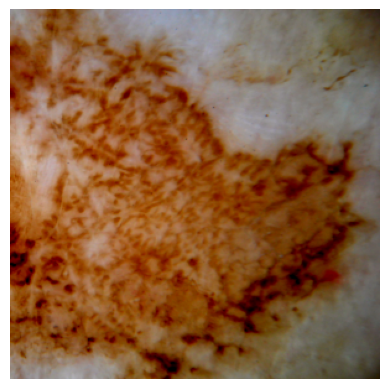

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

dataiter = iter(loader_train)
sample = next(dataiter)

inputs, labels = sample
print(inputs.size())
image = inputs[0].numpy()
image = np.transpose(image, (1, 2, 0))

plt.imshow(image)
plt.axis('off')
plt.show()

### Import necessary libraries

In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 1.5 MB/s eta 0:00:00


In [ ]:
import torch
import sys, os
import json
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim

# from torch.utils.tensorboard import SummaryWriter
import prettytable
import time, random, timeit
sys.setrecursionlimit(15000)

from PIL import Image
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from tqdm.notebook import tqdm
import seaborn as sns

from einops import rearrange, repeat,reduce
from einops.layers.torch import Rearrange
from torch import linalg as LA

In [ ]:
sys.path.append(os.pardir)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

best_acc = 0.
eval_acc = 0.
best_train = 0.
ratio = 8
reduction = 1
n_iter = 0

### Helper functions

In [ ]:
def squash(s):
    mag_sq = torch.sum(s**2, dim=2, keepdim=True)
    mag = torch.sqrt(mag_sq)
    s = (mag_sq / (1.0 + mag_sq)) * (s / mag)
    return s

def one_hot(x, length):
    batch_size = x.size(0)
    x_one_hot = torch.zeros(batch_size, length)
    for i in range(batch_size):
        x_one_hot[i, x[i]] = 1.0
    return x_one_hot

def autopad(k, p=None):
    # kernel, padding
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]
    return p

### Definition of Capsule Net

In [ ]:
class CapsNet(nn.Module):
    def __init__(self, conv_inputs, num_classes=2,
                 init_weights=False, conv_outputs = 128,
                 primary_units = 8, primary_unit_size = 576, # 16 * 6 * 6
                 output_unit_size = 16):
        super().__init__()

        self.Convolution = nn.Sequential(
            nn.Conv2d(conv_inputs, conv_outputs, 31, stride=2, groups=1, bias=False),
            nn.ReLU(inplace=True),
            nn.FractionalMaxPool2d(2, output_size=(20, 20))
            )

        # Channel Convolution
        self.CBAM = CBAM(conv_outputs, conv_outputs)

        self.primary = Primary_Caps(
            in_channels=conv_outputs,# 128
            caps_units=primary_units,# 8
        )

        self.digits = Digits_Caps(
            in_units=primary_units,# 8
            in_channels=primary_unit_size,# 16*6*6=576
            num_units=num_classes,# classification_num
            unit_size=output_unit_size,# 16
         )

        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.Convolution(x)
        x = self.CBAM(x)
        out = self.digits(self.primary(x))
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)

    # Margin loss
    def loss(self, img_input, target, size_average=True):
        batch_size = img_input.size(0)

        v_mag = torch.sqrt(torch.sum(img_input**2, dim=2, keepdim=True))
        zero = Variable(torch.zeros(1)).to(device)

        m_plus, m_minus = 0.9, 0.1
        max_l = torch.max(m_plus - v_mag, zero).view(batch_size, -1)**2
        max_r = torch.max(v_mag - m_minus, zero).view(batch_size, -1)**2

        loss_lambda = 0.5

        T_c = target
        L_c = T_c * max_l + loss_lambda * (1.0 - T_c) * max_r
        L_c = torch.sum(L_c,1)

        if size_average:
            L_c = torch.mean(L_c)

        return L_c

### Definition of Contrastive Learning Model

### Components of the Network

In [ ]:
class Primary_Caps(nn.Module):
    def __init__(self, in_channels, caps_units):
        super(Primary_Caps, self).__init__()

        self.in_channels = in_channels
        self.caps_units = caps_units

        def create_conv_unit(unit_idx):
            unit = ConvUnit(in_channels=in_channels)
            self.add_module("Caps_" + str(unit_idx), unit)
            return unit
        self.units = [create_conv_unit(i) for i in range(self.caps_units)]

    #no_routing
    def forward(self, x):
        # Get output for each unit.
        # Each will be (batch, channels, height, width).# [batch,16,6,6]
        u = [self.units[i](x) for i in range(self.caps_units)]
        # Stack all unit outputs (batch, unit, channels, height, width).
        u = torch.stack(u, dim=1)
        # Flatten to (batch, unit, output).
        u = u.view(x.size(0), self.caps_units, -1) # [batch,8,576]
        # Return squashed outputs.
        return squash(u)


class Digits_Caps(nn.Module):
    def __init__(self, in_units, in_channels, num_units, unit_size):
        super(Digits_Caps, self).__init__()

        self.in_units = in_units
        self.in_channels = in_channels
        self.num_units = num_units
        self.W = nn.Parameter(torch.randn(1, in_channels, self.num_units, unit_size, in_units))
        # self.w = [1,576,7,16,8]

    #routing
    def forward(self, x):
        batch_size = x.size(0)
        # (batch, in_units, features) -> (batch, features, in_units)
        x = x.transpose(1, 2)  #[batch,576,8]
        # (batch, features, in_units) -> (batch, features, num_units, in_units, 1)
        x = torch.stack([x] * self.num_units, dim=2).unsqueeze(4) # [batch, 576, 7, 8, 1]
        # (batch, features, in_units, unit_size, num_units)
        W = torch.cat([self.W] * batch_size, dim=0)
        # Transform inputs by weight matrix.
        # (batch_size, features, num_units, unit_size, 1)
        u_hat = torch.matmul(W, x) # [batch, 576, 7, 16, 1]
        # Initialize routing logits to zero.
        b_ij = Variable(torch.zeros(1, self.in_channels, self.num_units, 1)).to(device)

        num_iterations = 3
        for iteration in range(num_iterations):
            # Convert routing logits to softmax.
            # (batch, features, num_units, 1, 1)
            c_ij = b_ij.softmax(dim=1)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            # Apply routing (c_ij) to weighted inputs (u_hat).
            # (batch_size, 1, num_units, unit_size, 1)
            # [batch, 1, 7, 16, 1]
            s_j = torch.sum(c_ij * u_hat, dim=1, keepdim=True)

            # (batch_size, 1, num_units, unit_size, 1)
            v_j = squash(s_j) # CapsuleLayer.squash

            # (batch_size, features, num_units, unit_size, 1)
            # [batch, 576, 7, 16, 1]
            v_j1 = torch.cat([v_j] * self.in_channels, dim=1)

            # (1, features, num_units, 1)
            u_vj1 = torch.matmul(u_hat.transpose(3, 4), v_j1).squeeze(4).mean(dim=0, keepdim=True)

            # Update b_ij (routing)
            b_ij = b_ij + u_vj1

        return v_j.squeeze(1)



class ConvUnit(nn.Module):
    def __init__(self, in_channels):
        super(ConvUnit, self).__init__()
        Caps_out = in_channels // ratio # 16
        self.Cpas = nn.Sequential(
                        nn.Conv2d(in_channels,in_channels,(9,1),stride=1, bias=False),
                        nn.Conv2d(in_channels,Caps_out,(1,9),stride=2,groups=Caps_out, bias=False),
                    )

    def forward(self, x):
        output = self.Cpas(x)
        return output


class CBAM(nn.Module):
    def __init__(self, c1, c2, k=1, s=1, p=None, g=1, act=True):
        super(CBAM, self).__init__()
        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.Hardswish() if act else nn.Identity()
        self.ca = ChannelAttention(c2, reduction=reduction)
        self.sa = SpatialAttention()

    def forward(self, x):
        x = self.act(self.bn(self.conv(x)))
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x


class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=3): # default:3
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7)
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # The different channels are averaged and converted to 1 channel.
        avg_out = torch.mean(x, dim=1, keepdim=True)

        # Maximizing the different channels and making them 1-channel.
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)


class ChannelAttention(nn.Module):
    def __init__(self, channels, reduction=16):
        super(ChannelAttention, self).__init__()
        me_c = channels // reduction
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1   = nn.Conv2d(channels, me_c, 1, bias=False)
        self.relu1 = nn.ReLU(inplace=True)
        self.fc2   = nn.Conv2d(me_c, channels, 1, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)


class SENet(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SENet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)


class ECANet(nn.Module):
    def __init__(self, channel, k_size=3):
        """
        channel: Number of channels of the input feature map
        k_size: Adaptive selection of kernel size
        """
        super(ECANet, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(1, 1, kernel_size=k_size, padding=(k_size - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # feature descriptor on the global spatial information
        y = self.avg_pool(x)

        # Two different branches of ECA module
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)

        # Multi-scale information fusion
        y = self.sigmoid(y)

        return x * y.expand_as(x)

### Define Training and Testing procedure

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm


train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []

train_preds = []
train_labels = []


def train(max_epoch, device, loader_train, loader_val):
    global train_losses, val_losses
    global train_accs, val_accs
    global train_preds, train_labels
    global model, optimizer, scheduler

    best_val_loss = float('inf')
    best_model_state_dict = None

    for epoch in range(max_epoch):
        print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

        model.train()
        train_loss = 0.0
        batch_idx = 0
        r_pre = 0

        train_bar = tqdm(loader_train)

        for data in train_bar:
            batch_idx += 1

            images, labels = data
            labels_index = labels
            labels = one_hot(labels, length=n_classes)

            images, labels = Variable(images).to(device), Variable(labels).to(device)

            outputs = model(images)
            loss = model.loss(outputs, labels, size_average=True)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            v_mag = LA.norm(outputs, ord='nuc', dim=(2,3), keepdim=True)

            pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
            r_pre += pred.eq(labels_index.view_as(pred)).squeeze().sum()

        train_loss /= len(loader_train)
        train_losses.append(train_loss)

        # Convert tensors to NumPy arrays or lists
        labels_index = labels_index.cpu().numpy() if torch.is_tensor(labels_index) else labels_index.tolist()
        pred = pred.cpu().numpy() if torch.is_tensor(pred) else pred.tolist()

        # Calculate accuracy
        correct = np.sum(labels_index == pred)
        total = len(labels_index)
        train_acc = correct / total
        train_accs.append(train_acc)

        scheduler.step()

        print(f"Labels index: {labels_index}")
        print(f"Predictions: {pred}")


        print("Train Loss: {:.4f}, ACC: {:.4f}".format(train_loss, train_acc))

        ### Evaluate on validation set
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        r_pre = 0
        batch_idx = 0

        val_bar = tqdm(loader_val)

        for data in val_bar:
            batch_idx += 1

            images, labels = data
            labels_index = labels
            labels = one_hot(labels, length=n_classes)

            images, labels = Variable(images).to(device), Variable(labels).to(device)

            with torch.no_grad():
                outputs = model(images)
                loss = model.loss(outputs, labels, size_average=True)

            val_loss += loss.item()

            v_mag = LA.norm(outputs, ord='nuc', dim=(2,3), keepdim=True)
            pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
            r_pre += pred.eq(labels_index.view_as(pred)).squeeze().sum()

        val_loss /= len(loader_val)
        val_losses.append(val_loss)

        # Convert tensors to NumPy arrays or lists
        labels_index = labels_index.cpu().numpy() if torch.is_tensor(labels_index) else labels_index.tolist()
        pred = pred.cpu().numpy() if torch.is_tensor(pred) else pred.tolist()

        # Calculate accuracy
        correct = np.sum(labels_index == pred)
        total = len(labels_index)
        val_acc = correct / total
        val_accs.append(val_acc)

        print(f"Labels index: {labels_index}")
        print(f"Predictions: {pred}")

        print("Val Loss: {:.4f}, ACC: {:.4f}".format(val_loss, val_acc))

        ### Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()

    return best_model_state_dict

### Perform Training

In [ ]:
n_channels = 3 # RGB
n_classes = 2 # Disease or not

network = CapsNet(
        conv_inputs=n_channels,
        num_classes=n_classes,
        init_weights=True
    )

model = network.to(device)
learning_rate = 0.123
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, 5, eta_min=1e-8, last_epoch=-1)
num_epochs = 70

test_acc = 0
eval_acc = 0
best_acc = 0

net_parameters = None
test_evl_result = None
val_evl_result = None

val_acc_list = []
test_acc_list = []

In [ ]:
network.Convolution

Sequential(
  (0): Conv2d(3, 128, kernel_size=(31, 31), stride=(2, 2), bias=False)
  (1): ReLU(inplace=True)
  (2): FractionalMaxPool2d()
)

In [ ]:
best_model_state_dict = train(num_epochs, device, loader_train, loader_val)
torch.save(best_model_state_dict, 'best_model.pth')
print('Finished Training')

 -- Epoch 1/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 0 1 0 1 0 0
 1 1 1 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.7839, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1
 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.6853, ACC: 0.4808
 -- Epoch 2/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 0 0 1
 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 1 1 0 0
 0 0 1 1 0 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.5094, ACC: 0.5250


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1
 0 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2305, ACC: 0.3462
 -- Epoch 3/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 1 0 1 0 1 0 1
 1 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 1 1
 0 1 1 1 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2296, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 0 1 0 1 1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0
 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2142, ACC: 0.4808
 -- Epoch 4/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 0 0 1 0 1 0 0 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0
 1 0 0 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2150, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1
 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2143, ACC: 0.4423
 -- Epoch 5/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 0 0
 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0
 1 1 0 0 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2154, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2142, ACC: 0.2692
 -- Epoch 6/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1
 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1
 0 1 1 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2133, ACC: 0.4625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0
 1 1 1 1 1 0 0 1 1 0 0 1 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2136, ACC: 0.4231
 -- Epoch 7/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0
 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1
 1 1 1 1 1 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2135, ACC: 0.4750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 0 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0
 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2140, ACC: 0.4808
 -- Epoch 8/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 0
 1 1 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 1 0 0 0 1 0 0 0 1
 0 1 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2139, ACC: 0.4500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 1 0 1 1 0 0 1 1 0 1 1
 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2132, ACC: 0.5385
 -- Epoch 9/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 0 1 0 1 1 0 0 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 1 0 0 1 0 0 0 0
 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0
 1 0 1 1 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2134, ACC: 0.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2088, ACC: 0.5769
 -- Epoch 10/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 1 1 0 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 1 1 1
 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0
 0 1 0 0 0 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2139, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 1 0 0 1 1 1 0 1 0 0 0 1 1 1 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2160, ACC: 0.4231
 -- Epoch 11/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0
 0 1 1 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1
 0 1 1 0 0 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2135, ACC: 0.4875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 0 1 1 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 1 0 1 0
 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1]
Predictions: [1 1 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 1 1 1 0 0 1]
Val Loss: 0.2124, ACC: 0.7308
 -- Epoch 12/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 1 0
 1 1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 1
 1 1 0 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2140, ACC: 0.4500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 1
 0 0 0 1 1 0 1 1 0 1 0 1 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2069, ACC: 0.5962
 -- Epoch 13/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 1 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1
 0 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 1 0
 1 0 1 0 0 0]
Predictions: [1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1
 0 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2134, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 1
 1 0 1 1 0 0 1 0 0 0 0 0 1 1 0]
Predictions: [1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 0 1 0 1 1 1 1 1 1]
Val Loss: 0.2124, ACC: 0.5000
 -- Epoch 14/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 0 1 0 0 0 0 1 1 0 0 1 0 0 1
 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 1 1 1 0 1
 1 0 1 1 0 1]
Predictions: [1 0 0 0 1 1 0 0 1 0 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1
 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 0
 1 0 1 1 1 1]
Train Loss: 0.2128, ACC: 0.7000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 1 0 0 0 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0
 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0]
Predictions: [1 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1]
Val Loss: 0.2129, ACC: 0.5000
 -- Epoch 15/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 1
 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0 1
 0 1 1 0 0 0]
Predictions: [0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 1 1 0 0 0 1 0 0 1 0
 0 0 0 0 1 0 1 0 0 0 1 0 1 0 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1
 1 0 1 0 0 1]
Train Loss: 0.2105, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 0 1 1 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1
 0 1 1 1 1 0 0 0 0 0 1 1 1 1 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Val Loss: 0.2120, ACC: 0.4615
 -- Epoch 16/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 1 1 0 1 0 1 1 0 0 1 1
 0 1 1 1 0 1 1 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1
 1 0 0 1 1 0]
Predictions: [0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0
 0 1 1 0 0 0]
Train Loss: 0.2124, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1
 1 0 1 0 1 1 1 1 1 1 0 0 0 1 1]
Predictions: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0]
Val Loss: 0.2101, ACC: 0.4615
 -- Epoch 17/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 0
 0 0 1 1 0 0 1 0 1 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 0 0
 1 1 0 0 0 0]
Predictions: [0 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0
 0 0 0 1 1 0 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0
 0 1 0 0 0 1]
Train Loss: 0.2121, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0
 1 1 1 0 0 1 1 0 0 1 0 0 1 1 0]
Predictions: [1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 1 0 1
 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0]
Val Loss: 0.2129, ACC: 0.5577
 -- Epoch 18/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 1 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0
 1 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 0 1]
Predictions: [1 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 1 1 0 1
 1 1 1 1 1 1]
Train Loss: 0.2108, ACC: 0.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 0 0 1
 1 0 0 0 0 1 0 1 0 1 0 0 0 1 1]
Predictions: [1 0 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1]
Val Loss: 0.2134, ACC: 0.5385
 -- Epoch 19/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 1 0 0 1 0 0
 0 0 1 1 1 0 0 1 0 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 0
 1 0 0 1 0 0]
Predictions: [0 0 1 1 0 1 1 1 0 1 0 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0
 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0
 1 0 1 0 0 1]
Train Loss: 0.2089, ACC: 0.6000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 1 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 1 1 0
 1 0 1 1 0 0 1 0 0 0 1 1 0 0 1]
Predictions: [0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0
 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1]
Val Loss: 0.2031, ACC: 0.6346
 -- Epoch 20/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 0 0 1
 0 0 0 0 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 1
 1 1 1 1 1 0]
Predictions: [1 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 1
 0 1 0 0 0 0]
Train Loss: 0.2124, ACC: 0.5875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 0 1
 0 1 1 1 0 1 1 1 0 0 0 1 0 1 0]
Predictions: [0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 1 0
 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1]
Val Loss: 0.2150, ACC: 0.4231
 -- Epoch 21/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 1 0 0
 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 0 0 0 1 0
 0 1 1 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2122, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1
 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2436, ACC: 0.5192
 -- Epoch 22/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0
 0 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1
 1 0 1 0 1 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2170, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 0 1 1 0 0 1 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 0 1
 0 1 1 1 0 0 1 0 0 0 1 0 1 0 0]
Predictions: [1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1]
Val Loss: 0.2146, ACC: 0.5385
 -- Epoch 23/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0
 1 0 1 0 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 0 0 0 0 1
 0 1 1 0 1 0]
Predictions: [0 0 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 0 0 1
 0 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0 0 0
 0 0 1 0 0 1]
Train Loss: 0.2144, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 1
 1 1 1 0 1 0 0 1 1 1 1 0 1 0 1]
Predictions: [1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
Val Loss: 0.2113, ACC: 0.4423
 -- Epoch 24/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 0
 0 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 0 1 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 1
 0 1 0 0 0 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 0 1 0 1 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0]
Train Loss: 0.2111, ACC: 0.5250


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 1 0 0 0 1 0 1 1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0
 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1]
Val Loss: 0.2115, ACC: 0.5577
 -- Epoch 25/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 1 0
 1 1 0 1 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 1 0 0 1 1 0 1 0 0 1 1 0 1 1 0 1 1
 0 1 0 0 0 0]
Predictions: [0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 1 1
 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 1 0 1 1 1 1 0 1
 0 0 0 1 1 1]
Train Loss: 0.2081, ACC: 0.6250


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 1
 0 0 0 1 0 1 0 1 0 1 0 1 0 0 0]
Predictions: [0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1]
Val Loss: 0.2074, ACC: 0.6154
 -- Epoch 26/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 1 0 1 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0
 1 1 0 1 1 1]
Predictions: [1 1 0 1 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0
 0 1 0 1 0 0 1 1 0 1 0 0 1 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 1
 0 1 1 1 1 0]
Train Loss: 0.2119, ACC: 0.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 0 0 0 1 1
 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0]
Predictions: [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 1 1 0 0 0 0 0 1 0 1]
Val Loss: 0.2176, ACC: 0.4423
 -- Epoch 27/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 0 0 1 0 1 0 1 0 0
 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1
 0 1 1 1 1 1]
Predictions: [0 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0 1 1 0
 0 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 0 0 1 1 1 0 1 1 1 1 1 0
 1 1 1 0 1 0]
Train Loss: 0.2084, ACC: 0.6000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 1 0 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 1
 0 1 0 1 0 1 0 1 1 0 1 0 1 1 1]
Predictions: [0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0
 0 1 1 1 1 1 0 0 1 0 0 0 0 1 1]
Val Loss: 0.2062, ACC: 0.6346
 -- Epoch 28/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 1 1
 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0
 1 0 1 1 1 1]
Predictions: [1 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0
 0 1 0 0 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1
 1 0 1 1 0 1]
Train Loss: 0.2086, ACC: 0.5875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0
 0 1 1 0 0 0 0 1 1 0 0 0 1 1 1]
Predictions: [0 1 1 1 1 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 1 0
 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0]
Val Loss: 0.2166, ACC: 0.5769
 -- Epoch 29/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 0 1 1 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 0 1 0 1 1 0 1 1 0 1 1 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 0 1]
Train Loss: 0.2076, ACC: 0.6500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 0 1 1 1 0 1 1 1 0]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2543, ACC: 0.4423
 -- Epoch 30/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0
 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 1 1
 1 1 1 1 0 1]
Predictions: [1 1 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0
 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 0 1 1 0 1 1 1 0
 0 1 0 1 0 1]
Train Loss: 0.2152, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 1 0 1
 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1]
Predictions: [1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0
 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
Val Loss: 0.2152, ACC: 0.4615
 -- Epoch 31/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0
 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1
 0 0 0 1 1 1]
Predictions: [1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1
 0 1 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 0
 1 1 0 1 1 1]
Train Loss: 0.2138, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 1 1 1 1 0 0 1
 0 1 0 0 1 1 1 0 0 1 0 1 0 1 0]
Predictions: [1 1 1 0 1 0 1 0 1 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1
 0 0 0 1 0 1 1 0 1 0 0 1 0 1 0]
Val Loss: 0.2106, ACC: 0.6346
 -- Epoch 32/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 1 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1
 0 0 1 1 0 1 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0
 1 1 0 1 1 0]
Predictions: [0 1 1 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 0 1
 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1
 1 1 1 0 0 1]
Train Loss: 0.2110, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0
 1 1 0 0 0 0 1 0 1 0 1 0 1 0 1]
Predictions: [0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0
 0 0 0 0 1 0 1 0 0 0 0 1 0 1 1]
Val Loss: 0.2170, ACC: 0.5769
 -- Epoch 33/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 0 1 1 0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1
 0 0 1 1 1 0 1 1 0 0 0 1 0 1 1 0 1 1 1 1 0 1 0 0 0 0 0 1 0 1 1 1 1 0 0 0 1
 0 0 0 1 1 0]
Predictions: [0 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0
 0 0 0 0 1 0]
Train Loss: 0.2083, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 1 0 1 1 0 0 0 0 0 1 0 0 1 1 1 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 0 0 1
 1 0 1 1 0 0 0 0 0 1 1 1 0 0 1]
Predictions: [0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]
Val Loss: 0.2179, ACC: 0.5962
 -- Epoch 34/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 1 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 0 1 1 1 0 1 0 1 0
 0 0 0 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1
 0 1 0 0 0 1]
Predictions: [1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1
 1 1 1 1 1 1]
Train Loss: 0.2100, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0
 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1]
Predictions: [0 0 1 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1
 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1]
Val Loss: 0.2126, ACC: 0.4615
 -- Epoch 35/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 1 1 1 1 0 1
 0 0 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 1
 0 0 0 0 1 1]
Predictions: [0 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1
 1 1 0 0 1 0 0 1 0 1 1 0 1 1 0 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 1 0
 1 0 0 0 1 1]
Train Loss: 0.2075, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1
 1 1 0 1 0 0 0 0 1 1 0 1 0 1 0]
Predictions: [1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 1 0
 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1]
Val Loss: 0.2098, ACC: 0.5962
 -- Epoch 36/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1
 0 1 1 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1
 1 0 0 1 1 0]
Predictions: [1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 0 1
 1 1 0 1 1 0]
Train Loss: 0.2088, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1]
Predictions: [1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1]
Val Loss: 0.2101, ACC: 0.5769
 -- Epoch 37/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 1 0 1
 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 1 1 0 1 1 0 1
 0 0 1 0 0 1]
Predictions: [1 0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0
 1 1 1 1 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0
 1 1 1 0 0 0]
Train Loss: 0.2062, ACC: 0.5750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 1 1 0 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0
 1 0 0 0 1 1 0 1 1 0 0 1 0 0 0]
Predictions: [1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0
 1 0 0 1 0 1 1 0 0 0 1 0 1 1 1]
Val Loss: 0.2066, ACC: 0.5577
 -- Epoch 38/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 1 0 1 1 0 0 1
 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 1 0 0 0 0 1 1 0
 1 1 1 1 0 1]
Predictions: [1 0 0 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 0 1
 0 1 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1
 1 1 0 1 1 1]
Train Loss: 0.2105, ACC: 0.4625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 0
 0 1 1 1 0 0 1 1 0 0 1 0 0 1 0]
Predictions: [1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1]
Val Loss: 0.1999, ACC: 0.6154
 -- Epoch 39/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0
 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1
 1 0 1 1 0 0]
Predictions: [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2115, ACC: 0.3750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0
 0 1 1 1 1 0 0 1 1 1 0 1 1 0 1]
Predictions: [1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 0 0 1 0 0
 0 0 1 0 1 0 1 1 1 0 0 1 1 1 1]
Val Loss: 0.2028, ACC: 0.7308
 -- Epoch 40/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 1
 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 1 0 1 0 0 0
 1 0 0 0 0 1]
Predictions: [0 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 0 1 0 1
 1 0 1 1 0 1 1 0 0 0 0 1 1 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1
 0 0 1 0 1 0]
Train Loss: 0.2131, ACC: 0.5750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0 0 0 0
 0 0 1 0 0 0 1 0 0 1 0 0 1 1 0]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2680, ACC: 0.4808
 -- Epoch 41/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 1 0 1 1 1 1 1 0 1 0 1 1 0
 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 1 1 1 0 1
 0 1 1 1 0 1]
Predictions: [0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2101, ACC: 0.6500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 1 0
 0 0 1 0 1 0 0 0 1 1 1 0 1 1 1]
Predictions: [0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1
 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1]
Val Loss: 0.2071, ACC: 0.5769
 -- Epoch 42/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 0 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 0
 1 1 1 1 1 0 1 1 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 1 1
 0 0 0 1 1 1]
Predictions: [0 0 1 0 1 0 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0
 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 0
 0 1 1 1 1 1]
Train Loss: 0.2116, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 1 1 1 0 1 1 0 0 1 1 1 1 0
 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0]
Predictions: [1 1 1 1 0 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0
 0 0 0 1 0 0 1 0 0 0 0 1 0 0 1]
Val Loss: 0.2119, ACC: 0.5577
 -- Epoch 43/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 0 0 0 1 1 1 0 0 0 0 1 0 1 0 0 0 0 1 1 0 0 1
 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 0 1 1 0 1 1
 1 0 1 1 0 0]
Predictions: [1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0
 0 1 1 1 0 0]
Train Loss: 0.2036, ACC: 0.5500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 1 1 1 1 0 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 0
 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Val Loss: 0.2505, ACC: 0.4038
 -- Epoch 44/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 1
 1 1 1 0 0 0 1 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 0
 1 0 0 0 0 1]
Predictions: [1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 1 1 1]
Train Loss: 0.2136, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1]
Predictions: [1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2176, ACC: 0.5577
 -- Epoch 45/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 0 0 1 1 1 0 1 0 1 0 1 0 1 1 0 1
 1 1 1 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1 1
 0 1 0 0 1 0]
Predictions: [1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 0 0 1 0]
Train Loss: 0.2121, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 0 0 1
 0 1 0 1 1 1 0 0 0 1 1 0 0 0 0]
Predictions: [0 0 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0
 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2172, ACC: 0.4038
 -- Epoch 46/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 1 1 0 1 0 1 0 0 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 1
 0 1 1 0 0 0]
Predictions: [0 1 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 1 0 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1]
Train Loss: 0.2130, ACC: 0.4625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 0 1 1 1 1 1 1
 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0]
Predictions: [1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2094, ACC: 0.6154
 -- Epoch 47/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1
 0 0 0 1 1 0]
Predictions: [1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 1 0
 1 0 1 0 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 1 0 1]
Train Loss: 0.2052, ACC: 0.5750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 0 1 1 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 1 0 0 0
 0 1 1 0 0 1 1 0 1 1 0 1 1 1 0]
Predictions: [0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1]
Val Loss: 0.2146, ACC: 0.6154
 -- Epoch 48/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 1 0 0 0 1 1 0 1 0 0 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1
 1 0 1 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 1
 0 0 0 1 0 1]
Predictions: [0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1]
Train Loss: 0.2125, ACC: 0.5750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 0 0 0 1 0 0 1
 1 0 1 0 1 0 0 1 1 1 0 1 0 0 0]
Predictions: [0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1
 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0]
Val Loss: 0.2084, ACC: 0.7115
 -- Epoch 49/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1
 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 0 0
 0 1 0 1 1 1]
Predictions: [0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 0 1 0 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1
 1 1 0 1 1 1]
Train Loss: 0.2079, ACC: 0.6375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 0 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0
 0 1 0 0 0 1 0 0 1 0 1 1 1 0 0]
Predictions: [0 1 0 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 0 1 1 1 1
 0 1 0 1 1 1 0 0 1 0 1 1 0 1 0]
Val Loss: 0.2106, ACC: 0.5962
 -- Epoch 50/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 1 1 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 1 1 0 1
 1 0 0 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1]
Predictions: [1 1 1 0 1 1 0 0 0 0 1 1 1 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0 1
 0 1 1 1 0 0 1 0 1 1 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0
 1 1 1 0 0 1]
Train Loss: 0.2071, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 1 1
 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1]
Predictions: [1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2184, ACC: 0.5962
 -- Epoch 51/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 0 1 0 1 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 1 0 1 1 1 0 0 0
 0 0 1 0 0 0 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1
 0 0 1 0 1 1]
Predictions: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2123, ACC: 0.5375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 1 0 1 0 1 0 0 0 1 0 0 1
 1 1 0 0 1 1 1 1 0 1 1 0 0 0 1]
Predictions: [0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1]
Val Loss: 0.2111, ACC: 0.5769
 -- Epoch 52/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 1 1 0 1 0 0 1 1 1 0 0 0
 1 0 0 0 1 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 0 1
 0 1 0 0 0 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.2099, ACC: 0.5000


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 0
 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2130, ACC: 0.5577
 -- Epoch 53/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 0 0 0 1 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 1 1 1 1 0 1
 0 0 0 1 1 1 0 1 0 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 1 1 1 1]
Predictions: [1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]
Train Loss: 0.2133, ACC: 0.4875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1
 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1]
Predictions: [0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Val Loss: 0.2176, ACC: 0.5962
 -- Epoch 54/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 1 0 0 1 0 1 1 0 1 0
 1 1 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 1 1
 0 1 1 0 1 0]
Predictions: [0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 1 0 1 1 0
 1 1 0 1 0 0 0 1 1 0 1 0 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 1 0 0 1 1 1
 1 0 0 1 1 0]
Train Loss: 0.2067, ACC: 0.5875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 0 0
 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1]
Predictions: [0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 1 1 0 1 0
 1 1 1 0 1 1 1 1 1 0 1 0 1 0 0]
Val Loss: 0.2061, ACC: 0.6346
 -- Epoch 55/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 0 0 1 1 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0
 0 0 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1 0 0 1 1
 1 0 1 0 0 1]
Predictions: [1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
 1 1 1 0 0 0 0 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 0 1]
Train Loss: 0.2058, ACC: 0.5875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 1 0 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1
 0 0 1 1 0 0 0 0 1 0 0 1 1 1 0]
Predictions: [1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0 1 0 1 1 1 0 1 1
 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0]
Val Loss: 0.2063, ACC: 0.5962
 -- Epoch 56/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 0
 1 0 1 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 0 1 1
 1 1 1 1 0 1]
Predictions: [0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 0 0 0 1
 1 1 0 1 0 0 1 0 1 1 1 0 0 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 1 0 1 1 1
 1 1 0 1 0 1]
Train Loss: 0.2086, ACC: 0.5125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 1 1 1 0 1 1 1 0 0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0
 1 1 0 1 1 1 0 0 1 1 1 1 1 0 0]
Predictions: [1 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 0
 1 1 1 1 0 0 0 0 1 1 0 1 0 1 1]
Val Loss: 0.2065, ACC: 0.6154
 -- Epoch 57/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 1 0 1 0 0 1 0 1
 1 1 1 1 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 0 0 0
 0 1 1 0 0 0]
Predictions: [0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0
 0 0 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1
 0 1 1 0 1 1]
Train Loss: 0.2021, ACC: 0.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 0 1 0 0 1 0 1 1 0 0 1
 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0]
Predictions: [0 0 0 1 0 1 0 1 0 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 0 0 1 1 1
 0 1 1 1 1 0 1 1 1 1 0 0 0 0 1]
Val Loss: 0.2009, ACC: 0.5962
 -- Epoch 58/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 0 1 1 0 1 1 0 1 0 0
 1 1 0 1 0 1 0 0 0 1 1 0 0 0 0 1 0 0 1 1 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 1 0 0]
Predictions: [0 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 1 1 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 1 0
 1 1 1 1 0 0]
Train Loss: 0.2013, ACC: 0.6875


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 1 1 0 1 0 0 0 1 0 0 0 0]
Predictions: [0 0 1 1 0 0 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 1 0 1 1 1
 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0]
Val Loss: 0.1987, ACC: 0.6538
 -- Epoch 59/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 1 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0
 1 1 0 1 1 1 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 1 1
 1 0 0 1 1 1]
Predictions: [1 0 1 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 0 0 0 0 1 1 1 1 1 1 0 0 1 1 1 0
 1 1 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1
 1 0 0 1 0 1]
Train Loss: 0.2032, ACC: 0.6375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0
 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2384, ACC: 0.5192
 -- Epoch 60/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 0 0 1 0 1
 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 0 1 1 0 0 1 1 0 1 1
 1 0 1 1 0 0]
Predictions: [0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 0 0]
Train Loss: 0.2080, ACC: 0.5625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 1 0 1 0 1 0 0 1 1 0
 1 0 0 1 1 0 1 1 0 0 1 0 0 1 0]
Predictions: [1 0 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 1 1
 1 1 0 0 1 1 0 1 1 1 1 1 1 1 0]
Val Loss: 0.2025, ACC: 0.5577
 -- Epoch 61/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 1 0 0 0
 1 1 1 0 0 1]
Predictions: [0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1
 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0
 1 1 1 1 0 1]
Train Loss: 0.2062, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 1 0 0 1 1 1 1 1 1 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 0 0
 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1]
Predictions: [0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 1 0 0 0 0 0 1 0 1 0 0 0 1 0]
Val Loss: 0.2037, ACC: 0.6538
 -- Epoch 62/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 1 0 0 1 0 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 1 1
 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 0 1 0 1 0 0
 0 1 1 1 1 1]
Predictions: [1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 0
 0 1 1 1 0 1]
Train Loss: 0.2032, ACC: 0.6375


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 1 1 0 1 0
 1 1 1 0 1 0 0 1 1 0 1 0 0 1 1]
Predictions: [0 0 1 0 1 1 1 0 1 1 1 0 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 1 1 0 1 1
 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1]
Val Loss: 0.1903, ACC: 0.7500
 -- Epoch 63/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 1 1 1
 0 1 1 1 1 0 1 1 0 1 0 0 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 0 0
 1 0 0 0 1 0]
Predictions: [1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 0 1
 1 1 1 0 1 0]
Train Loss: 0.2016, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 1 1 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1]
Predictions: [1 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 1 0 0 0 1
 1 0 0 1 0 1 1 1 1 0 1 0 1 0 1]
Val Loss: 0.1943, ACC: 0.5962
 -- Epoch 64/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1
 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1
 1 0 1 0 0 0]
Predictions: [1 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 1
 1 0 1 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1]
Train Loss: 0.1955, ACC: 0.5750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 1
 1 1 0 0 1 1 0 0 1 0 1 0 0 1 1]
Predictions: [1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1]
Val Loss: 0.2109, ACC: 0.6923
 -- Epoch 65/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 1 0 1 0 0 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 0
 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0
 1 0 0 0 1 1]
Predictions: [0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0
 0 0 1 0 0 0]
Train Loss: 0.2041, ACC: 0.4750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 1 1
 0 1 0 0 1 0 0 1 0 1 0 1 1 1 0]
Predictions: [1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.2193, ACC: 0.5385
 -- Epoch 66/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 0 1 1 0 1 1 0 0 1 1 0 1 1 1 1 0
 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 0 0 1 0 0 0
 1 0 1 0 1 0]
Predictions: [1 1 1 1 1 1 0 0 0 0 1 1 1 1 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1
 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0 0 0 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0 1 0
 0 0 1 0 0 0]
Train Loss: 0.1953, ACC: 0.6500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 1 1 1 1 1 1 0 1 0 1 0 0 0 1 0 1 1 0 0 0 1 1 0 1 0 1 1 1 0 1 1 0 0 1 1
 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1]
Predictions: [1 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1
 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1]
Val Loss: 0.1790, ACC: 0.7885
 -- Epoch 67/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 0 0 0 1 0 1 0 0 1 1 0 1 1 0 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1
 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1
 0 1 1 0 0 0]
Predictions: [1 0 0 1 1 0 1 1 0 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0
 0 0 1 1 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1
 0 1 1 0 0 0]
Train Loss: 0.1974, ACC: 0.6125


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1
 0 1 0 0 0 0 0 1 1 0 1 1 1 0 0]
Predictions: [1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 1 0 1
 1 1 0 0 0 1 1 1 0 0 1 0 1 1 0]
Val Loss: 0.1887, ACC: 0.6346
 -- Epoch 68/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 0 0 1 0 1 0 1 0 0 1 1 0 1 0 0 0 0 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 0 0 0 0
 1 0 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 0 0 1 0 1
 0 1 0 1 1 0]
Predictions: [0 1 1 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0
 0 0 1 1 0 1 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1
 1 0 0 1 1 1]
Train Loss: 0.1967, ACC: 0.6750


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 1 0 1 1 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 1 0 1 1 0
 1 0 0 1 0 0 0 0 1 1 1 0 1 0 1]
Predictions: [1 1 1 1 1 1 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 1 0 0 0 1 1 0 0 0 0 1 1 0 1 0 1
 1 0 1 1 0 0 0 1 1 1 0 1 0 1 1]
Val Loss: 0.1918, ACC: 0.6731
 -- Epoch 69/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [1 1 1 1 0 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 0 0 1 1 0 1 1 0 0 1 0 0
 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 0 1 0
 1 0 1 1 0 0]
Predictions: [0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0
 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 0 1 0
 1 1 0 1 0 1]
Train Loss: 0.1929, ACC: 0.6625


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [0 1 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 1 0 1 1 0 0 1 0 1 1
 0 1 1 0 0 0 0 0 0 1 1 0 0 1 1]
Predictions: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Val Loss: 0.3349, ACC: 0.5000
 -- Epoch 70/70


  0%|          | 0/6 [00:00<?, ?it/s]

Labels index: [0 1 1 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 0
 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 1 0 0 1 1 1 0 0 1 0 1 1 1
 0 0 0 0 0 1]
Predictions: [0 0 1 1 0 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 0 0
 0 1 0 0 0 0 1 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0
 1 1 1 0 0 0]
Train Loss: 0.2047, ACC: 0.6500


  0%|          | 0/2 [00:00<?, ?it/s]

Labels index: [1 0 0 1 0 0 0 0 1 0 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 0 1 1 1 1 1 0 1 1 1 1
 0 0 1 1 0 0 0 0 1 1 0 1 1 0 1]
Predictions: [0 0 0 1 1 0 0 0 0 1 1 0 1 1 1 0 1 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 0 1 1 1
 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0]
Val Loss: 0.1971, ACC: 0.6731
Finished Training


In [1]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[70:], label='Train Loss')
plt.plot(epochs, val_losses[70:], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()

epochs = range(1, len(train_accs[70:]) + 1)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs[70:], label='Train ACC')

plt.plot(epochs, val_accs[70:], label='Val ACC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train and Val ACC')
plt.legend()

plt.tight_layout()
plt.show()

NameError: name 'num_epochs' is not defined

In [ ]:
torch.cuda.memory.empty_cache()

### Perform Pseudo Labeling

In [ ]:
# Define the paths
unlabeled_data_path = "/content/ISBI2016_ISIC_Part1_Training_Data"
destination_path = '/content/dataset/unlabel'
destination_unlabeled_path = os.path.join(destination_path, 'unlabel')

# Create the destination "unlabel" folder if it doesn't exist
os.makedirs(destination_unlabeled_path, exist_ok=True)

# Move the unlabeled images to the "unlabel" folder
for filename in os.listdir(unlabeled_data_path):
    source_file = os.path.join(unlabeled_data_path, filename)
    destination_file = os.path.join(destination_unlabeled_path, filename)
    shutil.move(source_file, destination_file)

In [ ]:
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder


# Define the paths
unlabeled_data_path = "/content/ISBI2016_ISIC_Part1_Training_Data"
destination_path = '/content/dataset'
destination_unlabeled_path = os.path.join(destination_path, 'unlabel')

labeled_data_path = os.path.join(destination_path, 'relabeled')
benign_data_path = os.path.join(labeled_data_path, 'benign')
maligned_data_path = os.path.join(labeled_data_path, 'maligned')

os.makedirs(destination_unlabeled_path, exist_ok=True)
os.makedirs(benign_data_path, exist_ok=True)
os.makedirs(maligned_data_path, exist_ok=True)


# Move the unlabeled images to the "unlabel" folder
for filename in os.listdir(unlabeled_data_path):
    source_file = os.path.join(unlabeled_data_path, filename)
    destination_file = os.path.join(destination_unlabeled_path, filename)
    os.rename(source_file, destination_file)

# Define the transformation to apply to the images
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create a custom dataset class for the unlabeled images
class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_folder = ImageFolder(self.data_path, transform=self.transform)

    def __getitem__(self, index):
        image, _ = self.image_folder[index]
        return image

    def __len__(self):
        return len(self.image_folder)


unlabeled_dataset = UnlabeledDataset(destination_unlabeled_path, transform=transform)
batch_size = 128
loader_unlabeled = torch.utils.data.DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=False)

torch.Size([128, 3, 299, 299])


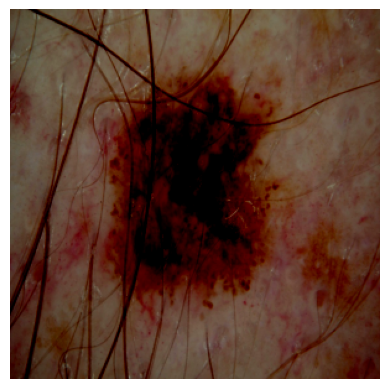

In [ ]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


dataiter = iter(loader_unlabeled)
sample = next(dataiter)

inputs, labels = sample
print(inputs.size())
image = inputs[0].numpy()
image = np.transpose(image, (1, 2, 0))

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Load the trained model
new_model = CapsNet(conv_inputs=n_channels, num_classes=n_classes, init_weights=True)
new_model.load_state_dict(torch.load('best_model.pth'))
new_model.eval()


# Predict on the unlabeled data
for batch_images in loader_unlabeled:
    with torch.no_grad():
        logits, _ = new_model(batch_images)

    predicted_labels = torch.argmax(logits, dim=1)
    for image, label in zip(batch_images, predicted_labels):
        image_filename = f'{label.item()}.jpg'
        if label == 0:
            image_filepath = os.path.join(benign_data_path, image_filename)
        else:
            image_filepath = os.path.join(maligned_data_path, image_filename)
        transforms.ToPILImage()(image).save(image_filepath)

In [ ]:
# Recreate the train dataset
root_train = "/content/dataset/relabeled"

batch_size = 128
loader_train, loader_val, loader_test = get_train_test_set(batch_size)

In [ ]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
train_aucs = []
val_aucs = []

train_preds = []
train_labels = []

test_acc = 0
eval_acc = 0
best_acc = 0

net_parameters = None
test_evl_result = None
val_evl_result = None

val_acc_list = []
test_acc_list = []

learning_rate = 0.00123

In [ ]:
num_epochs = 5

best_model_state_dict = train(num_epochs, device, loader_train, loader_val)
torch.save(best_model_state_dict, 'best_model.pth')
print('Finished Training')

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train ACC')
plt.plot(epochs, val_accs, label='Val ACC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train and Val ACC')
plt.legend()

plt.tight_layout()
plt.show()

### Define Pseudo Labeling With Technique

In [ ]:
def train(max_epoch, device, loader_train, loader_val, loader_unlabeled, T1, T2, alpha_f):
    global train_losses, val_losses
    global train_accs, val_accs
    global train_preds, train_labels
    global model, optimizer, scheduler

    best_val_loss = float('inf')
    best_model_state_dict = None

    # Train the initial model on the labeled dataset
    for epoch in range(max_epoch):
        # ... (your existing training loop for the labeled dataset)

    # Predict labels for the unlabeled dataset using the initial model
    model.eval()
    pseudo_labels = []
    for data in loader_unlabeled:
        images = data.to(device)
        with torch.no_grad():
            outputs = model(images)
            v_mag = LA.norm(outputs, ord='nuc', dim=(2, 3), keepdim=True)
            pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
            pseudo_labels.extend(pred.tolist())

    # Assign pseudo labels to the unlabeled dataset
    unlabeled_dataset = loader_unlabeled.dataset
    for i, sample in enumerate(unlabeled_dataset):
        sample.label = pseudo_labels[i]

    # Retrain the model using the augmented dataset
    for epoch in range(max_epoch):
        print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

        model.train()
        train_loss = 0.0
        batch_idx = 0
        r_pre = 0

        # Generate the augmented dataset for the current epoch
        augmented_dataset = DatasetGeneration(epoch, T1, T2, alpha_f, loader_train.dataset, unlabeled_dataset)
        augmented_loader = DataLoader(augmented_dataset, batch_size=loader_train.batch_size, shuffle=True)

        train_bar = tqdm(augmented_loader)

        for data in train_bar:
            batch_idx += 1

            images, labels = data
            labels_index = labels
            labels = one_hot(labels, length=n_classes)

            images, labels = Variable(images).to(device), Variable(labels).to(device)

            outputs = model(images)
            loss = model.loss(outputs, labels, size_average=True)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            train_loss += loss.item()

            v_mag = LA.norm(outputs, ord='nuc', dim=(2,3), keepdim=True)

            pred = v_mag.data.max(1, keepdim=True)[1].cpu().squeeze()
            r_pre += pred.eq(labels_index.view_as(pred)).squeeze().sum()

        train_loss /= len(augmented_loader)
        train_losses.append(train_loss)

        # ... (your existing code for calculating accuracy and evaluating on the validation set)

        ### Save the best model checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state_dict = model.state_dict()

    return best_model_state_dict

In [ ]:
def DatasetGeneration(t, T1, T2, alpha_f, labeled_dataset, unlabeled_dataset):
    augmented_dataset = []

    if t < T1:
        alpha = 0
    elif T1 <= t <= T2:
        alpha = (t - T1) / (T2 - T1) * alpha_f
    else:
        alpha = alpha_f

    for labeled_sample in labeled_dataset:
        unlabeled_sample = random.choice(unlabeled_dataset)
        augmented_image = alpha * labeled_sample[0] + (1 - alpha) * unlabeled_sample[0]
        augmented_label = labeled_sample[1]
        augmented_dataset.append((augmented_image, augmented_label))

    return augmented_dataset

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses[70:], label='Train Loss')
plt.plot(epochs, val_losses[70:], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Loss')
plt.legend()

epochs = range(1, len(train_accs[70:]) + 1)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs[70:], label='Train ACC')

plt.plot(epochs, val_accs[70:], label='Val ACC')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Train and Val ACC')
plt.legend()

plt.tight_layout()